## Installing and Importing libraries

In [41]:
import numpy as np
import pandas as pd
import librosa

In [42]:
import warnings

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
from keras.callbacks import ReduceLROnPlateau

In [46]:
import matplotlib.pyplot as plt

## Setting up dataset from Kaggle

In [49]:
! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73050 sha256=a5e35cc3ff2eaac9119923ba6a63d0151c67a6b1b6f36d7cdede54fffe380949
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [50]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bluecoder1206","key":"89cfc5c1eedf7d9f4e20380e8c324304"}'}

In [51]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [52]:
! chmod 600 ~/.kaggle/kaggle.json

In [53]:
#https://www.kaggle.com/datasets/imsparsh/4q-audio-emotion-dataset-russell
! kaggle datasets download -d imsparsh/4q-audio-emotion-dataset-russell

 96% 273M/285M [00:02<00:00, 61.5MB/s]
100% 285M/285M [00:03<00:00, 98.7MB/s]


In [54]:
!unzip 4q-audio-emotion-dataset-russell.zip -d dataset

Archive:  4q-audio-emotion-dataset-russell.zip
  inflating: dataset/MER Audio/Q1/MT0000040632.mp3  
  inflating: dataset/MER Audio/Q1/MT0000082187.mp3  
  inflating: dataset/MER Audio/Q1/MT0000249842.mp3  
  inflating: dataset/MER Audio/Q1/MT0000364027.mp3  
  inflating: dataset/MER Audio/Q1/MT0000392975.mp3  
  inflating: dataset/MER Audio/Q1/MT0000414517.mp3  
  inflating: dataset/MER Audio/Q1/MT0000442827.mp3  
  inflating: dataset/MER Audio/Q1/MT0000540286.mp3  
  inflating: dataset/MER Audio/Q1/MT0000664362.mp3  
  inflating: dataset/MER Audio/Q1/MT0000992846.mp3  
  inflating: dataset/MER Audio/Q1/MT0001053268.mp3  
  inflating: dataset/MER Audio/Q1/MT0001189913.mp3  
  inflating: dataset/MER Audio/Q1/MT0001217651.mp3  
  inflating: dataset/MER Audio/Q1/MT0001236649.mp3  
  inflating: dataset/MER Audio/Q1/MT0001335920.mp3  
  inflating: dataset/MER Audio/Q1/MT0001340713.mp3  
  inflating: dataset/MER Audio/Q1/MT0001418045.mp3  
  inflating: dataset/MER Audio/Q1/MT0001521543.mp3  

## Feature Extraction

In [121]:
anno = pd.read_csv("/content/dataset/MER Audio/panda_dataset_taffc_annotations.csv")
#anno.head()

In [122]:
labels = list(anno['Quadrant'].unique())

In [123]:
path_list = []
quad_list = []
for i in range(len(anno)):
    path = '/content/dataset/MER Audio/{}/{}.mp3'.format(anno['Quadrant'][i],anno['Song'][i])
    path_list.append(path)
    quad_list.append(anno['Quadrant'][i])
    
files = {"Path" : path_list, "Class" : quad_list}
data = pd.DataFrame(files)
data.head()

,Path,Class
0,/content/dataset/MER Audio/Q3/MT0000004637.mp3,Q3
1,/content/dataset/MER Audio/Q2/MT0000011357.mp3,Q2
2,/content/dataset/MER Audio/Q2/MT0000011975.mp3,Q2
3,/content/dataset/MER Audio/Q1/MT0000040632.mp3,Q1
4,/content/dataset/MER Audio/Q3/MT0000044741.mp3,Q3


In [130]:
def extract_features(df):
    features = []
    for i, r in df.iterrows():
        path = df["Path"][i]
        class_label = df["Class"][i]
        print(path)
        
        audio, sample_rate = librosa.load(path, res_type = 'kaiser_fast')
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mean_mfcc = np.mean(mfcc,axis=1)
        #ms = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40)
        #mean_ms = np.mean(ms.T,axis=0)
        print(mean_mfcc)
        features.append(mean_mfcc)
        '''
        if mean_mfcc.any():
            features.append(mean_mfcc)
        else:
            features.append(mean_ms)
        '''    
    features_data = pd.DataFrame(features)
    features_data['Class'] = df['Class']     
    return features_data

In [62]:
warnings.filterwarnings("ignore")

In [63]:
features_data = extract_features(data)

In [65]:
features_data.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Class
0,-233.763123,105.293144,-37.035294,33.383995,-14.346704,-11.358422,-9.268774,2.145918,-17.854031,0.998558,...,0.849806,-1.896939,-5.633172,-3.551533,-2.577791,-1.190105,-2.165631,-0.566149,0.898771,Q3
1,-58.508404,101.550346,-73.787643,71.289879,-22.014040,25.886940,-13.503711,27.429348,-6.822861,15.434646,...,-1.784864,-3.754245,-0.660543,-3.517751,-4.844555,-1.463612,-8.098192,0.031633,-4.769098,Q2
2,16.410931,90.221443,-27.060678,51.063503,-1.610659,38.527634,-12.417948,24.851696,-6.319453,14.617049,...,-2.772637,-3.094062,-3.275012,-2.236512,-2.750444,-1.160119,-2.399416,-1.310384,-2.834877,Q2
3,-93.936775,103.568367,12.486053,36.848930,1.885131,25.878534,-2.451750,13.302483,-12.688809,7.228611,...,1.054123,-2.362620,1.501418,1.307274,0.773670,-2.275789,-2.534871,-4.217319,-2.529251,Q1
4,-120.355766,87.557556,-18.502779,36.747585,-5.777526,10.562883,-9.573497,16.812691,-13.847594,12.169445,...,-0.280220,1.310781,-2.150067,-2.071990,-2.655347,-4.025784,-3.562472,-4.217046,-0.073304,Q3


In [66]:
features_data.to_csv('features.csv')

## Preparing Test and Train Datasets

In [67]:
fdata = pd.read_csv("/content/features.csv")

In [68]:
fdata.drop(columns = 'Unnamed: 0', inplace = True)
fdata.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Class
0,-233.763120,105.293144,-37.035294,33.383995,-14.346704,-11.358422,-9.268774,2.145918,-17.854030,0.998558,...,0.849806,-1.896939,-5.633172,-3.551533,-2.577792,-1.190105,-2.165631,-0.566149,0.898771,Q3
1,-58.508404,101.550350,-73.787640,71.289880,-22.014040,25.886940,-13.503711,27.429348,-6.822861,15.434646,...,-1.784864,-3.754245,-0.660543,-3.517751,-4.844555,-1.463612,-8.098192,0.031633,-4.769098,Q2
2,16.410930,90.221440,-27.060678,51.063503,-1.610659,38.527634,-12.417948,24.851696,-6.319453,14.617049,...,-2.772637,-3.094062,-3.275012,-2.236512,-2.750444,-1.160119,-2.399416,-1.310384,-2.834878,Q2
3,-93.936775,103.568370,12.486052,36.848930,1.885131,25.878534,-2.451750,13.302483,-12.688809,7.228611,...,1.054123,-2.362620,1.501418,1.307274,0.773670,-2.275789,-2.534871,-4.217319,-2.529251,Q1
4,-120.355770,87.557556,-18.502779,36.747585,-5.777526,10.562883,-9.573497,16.812690,-13.847594,12.169445,...,-0.280220,1.310781,-2.150067,-2.071989,-2.655347,-4.025784,-3.562472,-4.217046,-0.073304,Q3


In [69]:
X = fdata.drop(columns = 'Class').iloc[: ,:-1].values
y = fdata['Class'].values

In [73]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((675, 39), (675, 4), (225, 39), (225, 4))

In [75]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [76]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((675, 39, 1), (675, 4), (225, 39, 1), (225, 4))

## Building and Training Model

In [253]:
model=Sequential()
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=4, activation='softmax'))

In [254]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
#model.summary()

In [255]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
11/11 [==============================] - 1s 43ms/step - loss: 1.4078 - accuracy: 0.2770 - val_loss: 1.3686 - val_accuracy: 0.3733
Epoch 2/50
11/11 [==============================] - 0s 25ms/step - loss: 1.3719 - accuracy: 0.3067 - val_loss: 1.3509 - val_accuracy: 0.4222
Epoch 3/50
11/11 [==============================] - 0s 24ms/step - loss: 1.3627 - accuracy: 0.2859 - val_loss: 1.3436 - val_accuracy: 0.4444
Epoch 4/50
11/11 [==============================] - 0s 24ms/step - loss: 1.3432 - accuracy: 0.3541 - val_loss: 1.3142 - val_accuracy: 0.4311
Epoch 5/50
11/11 [==============================] - 0s 26ms/step - loss: 1.3293 - accuracy: 0.3556 - val_loss: 1.2658 - val_accuracy: 0.4533
Epoch 6/50
11/11 [==============================] - 0s 22ms/step - loss: 1.3035 - accuracy: 0.3496 - val_loss: 1.2474 - val_accuracy: 0.4267
Epoch 7/50
11/11 [==============================] - 0s 23ms/step - loss: 1.2958 - accuracy: 0.3748 - val_loss: 1.2330 - val_accuracy: 0.4578
Epoch 8/50
11

## Accuracy and Loss 

8/8 [==============================] - 0s 4ms/step - loss: 0.9662 - accuracy: 0.5644
Accuracy of our model on test data :  56.44 %


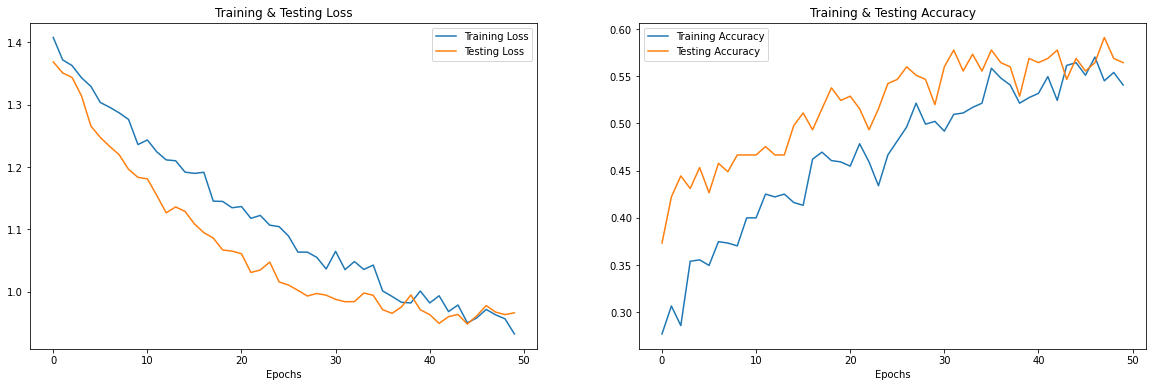

In [256]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100, 2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [257]:
import pickle
pickle.dump(model, open("model.pkl","wb"))

2022-11-15 19:49:34.125 WARNING absl: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ram://2497cd06-f886-4309-bdee-045f51702214/assets
2022-11-15 19:49:34.618 INFO    tensorflow: Assets written to: ram://2497cd06-f886-4309-bdee-045f51702214/assets


## Setting up Streamlit

In [80]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
!ngrok authtoken 2HajABYtMCgeKIM4qkA1rt8jpcw_29B1H1FkoxahWwPa6GLYP

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [84]:
from pyngrok import ngrok 
public_url = ngrok.connect(port='8501')
public_url

INFO:pyngrok.ngrok:Opening tunnel named: http-80-5a5b599f-5375-4f41-b2bf-3d7da1ac8ef4
2022-11-15 17:39:30.853 INFO    pyngrok.ngrok: Opening tunnel named: http-80-5a5b599f-5375-4f41-b2bf-3d7da1ac8ef4
INFO:pyngrok.process.ngrok:t=2022-11-15T17:39:30+0000 lvl=info msg="no configuration paths supplied"
2022-11-15 17:39:30.900 INFO    pyngrok.process.ngrok: t=2022-11-15T17:39:30+0000 lvl=info msg="no configuration paths supplied"
INFO:pyngrok.process.ngrok:t=2022-11-15T17:39:30+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2022-11-15 17:39:30.906 INFO    pyngrok.process.ngrok: t=2022-11-15T17:39:30+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2022-11-15T17:39:30+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2022-11-15 17:39:30.913 INFO    pyngrok.process.ngrok: t=2022-11-15T17:39:30+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngro

<NgrokTunnel: "http://015e-35-197-13-113.ngrok.io" -> "http://localhost:80">

2022-11-15 17:39:31.361 INFO    pyngrok.process.ngrok: t=2022-11-15T17:39:31+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-5a5b599f-5375-4f41-b2bf-3d7da1ac8ef4 addr=http://localhost:80 url=https://015e-35-197-13-113.ngrok.io
INFO:pyngrok.process.ngrok:t=2022-11-15T17:39:31+0000 lvl=info msg=end pg=/api/tunnels id=1611b6fc56ba7e35 status=201 dur=164.891992ms
2022-11-15 17:39:31.370 INFO    pyngrok.process.ngrok: t=2022-11-15T17:39:31+0000 lvl=info msg=end pg=/api/tunnels id=1611b6fc56ba7e35 status=201 dur=164.891992ms
INFO:pyngrok.process.ngrok:t=2022-11-15T17:39:31+0000 lvl=info msg=start pg="/api/tunnels/http-80-5a5b599f-5375-4f41-b2bf-3d7da1ac8ef4 (http)" id=eac8fd455bebf22b


## Streamlit App

In [258]:
%%writefile AudioAnalysisApp.py

import streamlit as st
import numpy as np
import pandas as pd
from pydub import AudioSegment
import librosa
import pickle
from sklearn.preprocessing import StandardScaler

mood = "Waiting for prediction"

def extract():
    features = []
    audio, sample_rate = librosa.load( '/content/audio.mp3', res_type = 'kaiser_fast')
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mean_mfcc = np.mean(mfcc,axis=1)
    #ms = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40)
    #mean_ms = np.mean(ms.T,axis=0)
    features.append(mean_mfcc)
    features_data = pd.DataFrame(features)
    return features_data

st.title("Audio Mood Analysis")

file = st.file_uploader("audio_file", type="mp3", label_visibility="visible")
st.write(mood)

if file is not None:
  file_var = AudioSegment.from_mp3(file) 
  file_var.export('audio.mp3', format='mp3')
  test_features = extract()
  test_features.drop(columns = test_features.columns[0], inplace = True)
  #print(test_features.head())
  Test_X = test_features.iloc[: ,:].values
  print(Test_X.shape)
  scaler = StandardScaler()
  Test_X = scaler.fit_transform(Test_X)
  Test_X = np.expand_dims(Test_X, axis=2)
  print(Test_X.shape)
  tmodel = pickle.load(open("model.pkl","rb"))
  p = tmodel.predict(Test_X)
  l = p.tolist()[0]
  qc1=l.index(max(l))
  mood = "Q"+str(qc1+1)
  st.write("Prediction: ",mood)

Writing AudioAnalysisApp.py


## Run app

In [ ]:
!streamlit run /content/AudioAnalysisApp.py & npx localtunnel --port 8501